# COVID-19 Impact on UK Air Travel Passengers

### Objective

Evaluate the impact of COVID-19 on number of commercial passengers travelling through UK airports during the period January 2020 until June 2022.

### Methodology

Model: I opted for Prophet as a simple model for time series forecasting.

Data: I used the historical statistics of monthly commercial passengers reported by London Heathrow website for the period between January 2005 and June 2022. For features, I used the UK holidays calendar embedded in Prophet model as well as simple calendar features.  

### Packages

You may uncomment the relevant lines in the following chunk to install the required packages. 

In [ ]:
#!pip install -U scikit-learn scipy matplotlib
#!pip install seaborn
#!pip install -U fbprophet

Import 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from prophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

We have prepared our dataset separately and we can directly load clean version from attached dataset.csv file. As Date column is typically assigned type Object by Pandas, we will change that to datetime type.

In [3]:
df = pd.read_csv(
    'prophetdataset.csv', 
    sep=';', 
    decimal=",", 
    parse_dates=True
)

df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          210 non-null    datetime64[ns]
 1   month         210 non-null    int64         
 2   year          210 non-null    int64         
 3   weekdays      210 non-null    int64         
 4   calendardays  210 non-null    int64         
 5   weekends      210 non-null    int64         
 6   Passengers    210 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 11.6 KB


### Exploratory Data Analysis

Let's start with some summary statistics from our dataset.

In [5]:
df.describe()

,month,year,weekdays,calendardays,weekends,Passengers
count,210.000000,210.000000,210.000000,210.000000,210.000000,2.100000e+02
mean,6.414286,2013.257143,22.452381,29.847619,7.395238,5.440152e+06
std,3.459234,5.068013,0.997662,0.513566,0.870009,1.629368e+06
min,1.000000,2005.000000,20.000000,28.000000,6.000000,2.066000e+05
25%,3.000000,2009.000000,22.000000,30.000000,7.000000,5.187086e+06
50%,6.000000,2013.000000,22.000000,30.000000,7.000000,5.803688e+06
75%,9.000000,2018.000000,23.000000,30.000000,8.000000,6.418989e+06
max,12.000000,2022.000000,24.000000,30.000000,9.000000,7.812309e+06


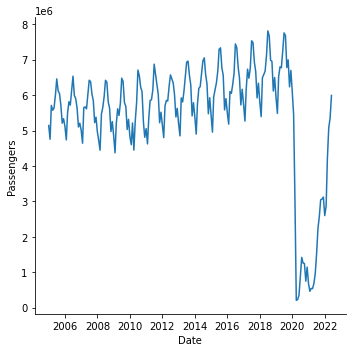

In [6]:
sns.relplot(x='Date', y='Passengers', kind='line', data=df)
plt.show()

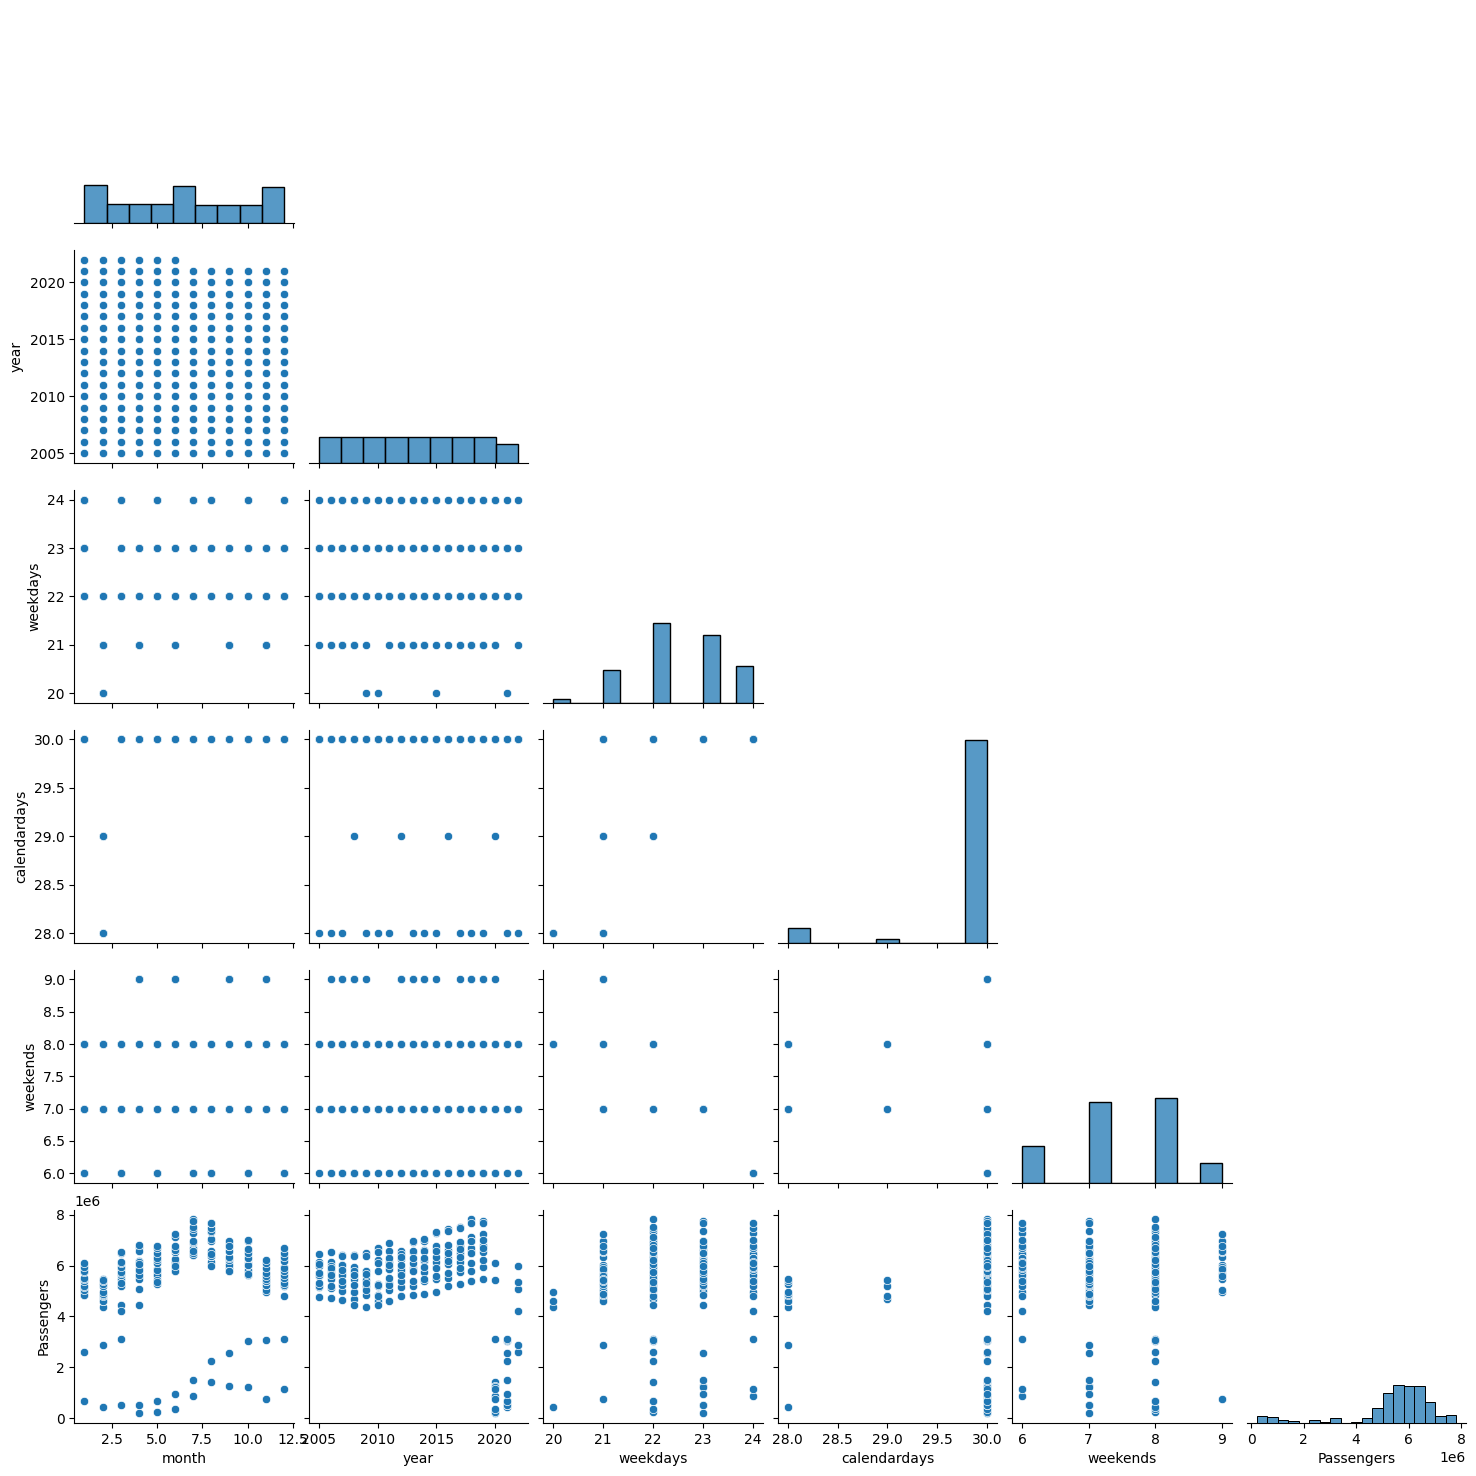

In [7]:
sns.pairplot(df,corner=True)
plt.show()

In [8]:
from scipy.stats import levene, shapiro
int_cols=df.select_dtypes(exclude='object').columns.to_list()

for i in int_cols:
    _, p_value=shapiro(df[i])
    if p_value<0.05:
        print("Feature {} is normally distributed".format(i))
    else:
        print("Feature {} is not normally distributed".format(i))
        
    print("Normalitiy test p_value for featue -  {} is {}".format(i,np.round(p_value,3)))

Feature Date is normally distributed
Normalitiy test p_value for featue -  Date is 0.0
Feature month is normally distributed
Normalitiy test p_value for featue -  month is 0.0
Feature year is normally distributed
Normalitiy test p_value for featue -  year is 0.0
Feature weekdays is normally distributed
Normalitiy test p_value for featue -  weekdays is 0.0
Feature calendardays is normally distributed
Normalitiy test p_value for featue -  calendardays is 0.0
Feature weekends is normally distributed
Normalitiy test p_value for featue -  weekends is 0.0
Feature Passengers is normally distributed
Normalitiy test p_value for featue -  Passengers is 0.0


<AxesSubplot:>

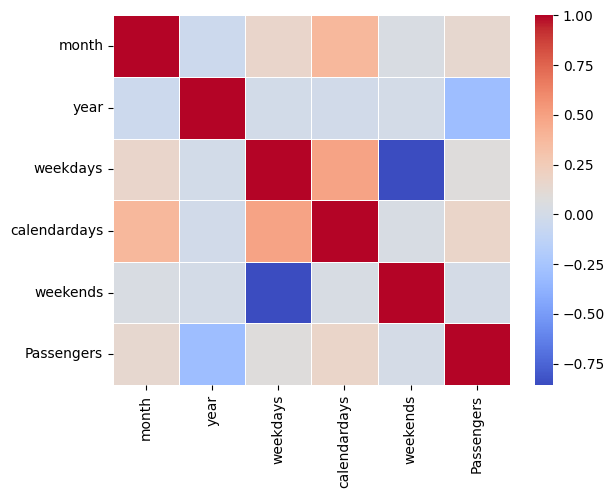

In [9]:
sns.heatmap(df.corr(), linecolor='white', cmap="coolwarm", linewidth=0.5)

In [10]:
columns = list(df)

In [11]:
data = df[columns]
data.dropna(inplace=True)
data = data.rename(columns={'Date':'ds', 'Passengers':'y'})

In [12]:
data.head()

,ds,month,year,weekdays,calendardays,weekends,y
0,2005-01-01,1,2005,22,30,8,5141123.0
1,2005-02-01,2,2005,21,28,7,4753591.0
2,2005-03-01,3,2005,24,30,6,5708627.0
3,2005-04-01,4,2005,22,30,8,5573022.0
4,2005-05-01,5,2005,22,30,8,5636621.0


# Train / Test Split

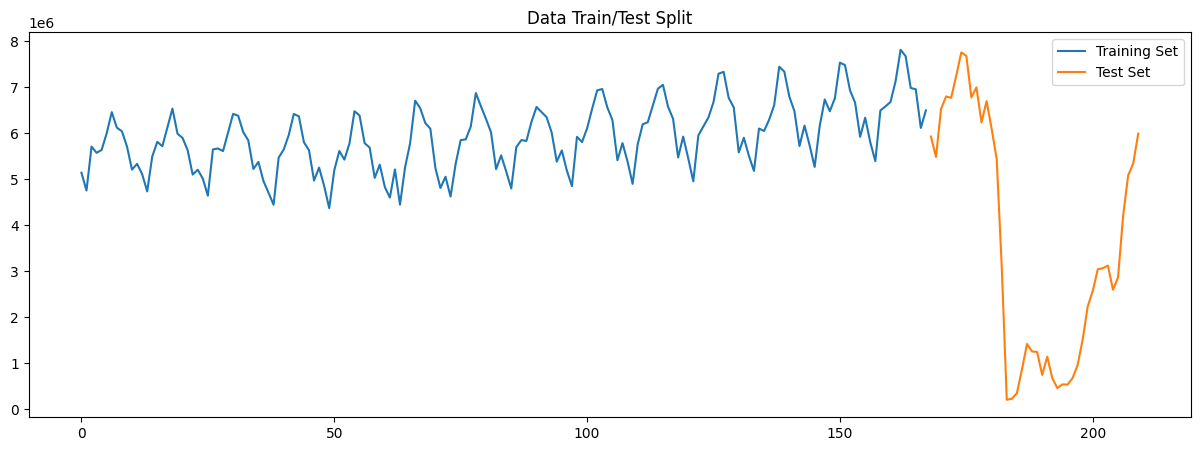

In [13]:
train = data.loc[data['ds'] < '2019-01-01']
test = data.loc[data['ds'] >= '2019-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train['y'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['y'].plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [14]:
train.tail()

,ds,month,year,weekdays,calendardays,weekends,y
163,2018-08-01,8,2018,24,30,6,7671950.0
164,2018-09-01,9,2018,21,30,9,6982147.0
165,2018-10-01,10,2018,23,30,7,6954019.0
166,2018-11-01,11,2018,23,30,7,6113761.0
167,2018-12-01,12,2018,22,30,8,6495487.0


In [15]:
test.head()

,ds,month,year,weekdays,calendardays,weekends,y
168,2019-01-01,1,2019,24,30,6,5927543.0
169,2019-02-01,2,2019,21,28,7,5482288.0
170,2019-03-01,3,2019,22,30,8,6527489.0
171,2019-04-01,4,2019,22,30,8,6798212.0
172,2019-05-01,5,2019,24,30,6,6768903.0


In [16]:
regressors = list(columns[1:-1])

In [17]:
regressors

['month', 'year', 'weekdays', 'calendardays', 'weekends']

In [18]:
m = Prophet(
    seasonality_mode="multiplicative", 
    n_changepoints= 4,
) 

In [19]:
m.add_country_holidays(
    country_name = 'UK'
)

In [20]:
for r in regressors:
    m = m.add_regressor(
        name=r
    )

In [21]:
m.fit(train)

11:57:36 - cmdstanpy - INFO - Chain [1] start processing
11:57:38 - cmdstanpy - INFO - Chain [1] done processing
11:57:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
11:57:38 - cmdstanpy - INFO - Chain [1] start processing
11:57:38 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future = test.drop(columns='y')

In [30]:
future.head()

,ds,month,year,weekdays,calendardays,weekends
168,2019-01-01,1,2019,24,30,6
169,2019-02-01,2,2019,21,28,7
170,2019-03-01,3,2019,22,30,8
171,2019-04-01,4,2019,22,30,8
172,2019-05-01,5,2019,24,30,6


In [32]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
37,2022-02-01,3.750888e+06,5.434766e+06,5.903008e+06,3.679492e+06,3.806994e+06,0.0,0.0,0.0,0.0,...,-0.178655,-0.178655,-0.178655,4.532965,4.532965,4.532965,0.0,0.0,0.0,5.666710e+06
38,2022-03-01,3.758276e+06,6.513302e+06,7.021076e+06,3.684835e+06,3.816293e+06,0.0,0.0,0.0,0.0,...,-0.178655,-0.178655,-0.178655,3.819903,3.819903,3.819903,0.0,0.0,0.0,6.775076e+06
39,2022-04-01,3.766456e+06,6.767838e+06,7.292009e+06,3.689801e+06,3.829133e+06,0.0,0.0,0.0,0.0,...,-0.178655,-0.178655,-0.178655,3.059254,3.059254,3.059254,0.0,0.0,0.0,7.029378e+06
40,2022-05-01,3.774372e+06,6.900394e+06,7.423672e+06,3.694055e+06,3.841735e+06,0.0,0.0,0.0,0.0,...,-0.178655,-0.178655,-0.178655,2.279242,2.279242,2.279242,0.0,0.0,0.0,7.168500e+06
41,2022-06-01,3.782552e+06,7.361523e+06,7.902642e+06,3.698335e+06,3.853324e+06,0.0,0.0,0.0,0.0,...,-0.178655,-0.178655,-0.178655,1.590993,1.590993,1.590993,0.0,0.0,0.0,7.634387e+06


In [31]:
forecast = m.predict(future)

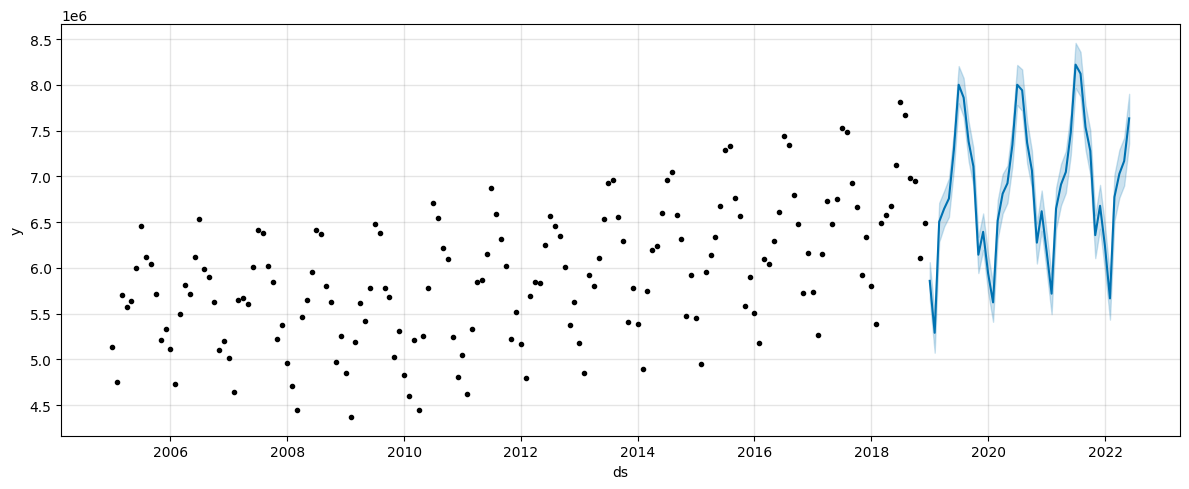

In [34]:
forecast_plot = m.plot(forecast, figsize=(12,5))

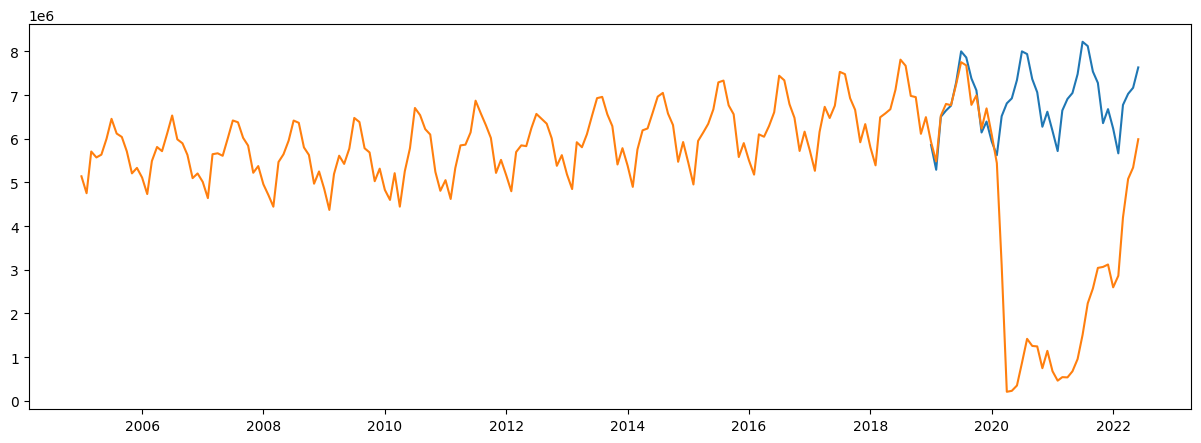

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(forecast['ds'], forecast['yhat'])
plt.plot(data['ds'], data['y'])
plt.show()

# 2019 Forecast Performance 

In [39]:
score = np.sqrt(mean_squared_error(data[-42:-30]['y'], forecast[:-30]['yhat']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 230576.61


In [40]:
mae = (mean_absolute_error(data[-42:-30]['y'], forecast[:-30]['yhat']))
print(f'MAE Score on Test set: {mae:0.2f}')

MAE Score on Test set: 168978.55


In [41]:
mape = (mean_absolute_percentage_error(data[-42:-30]['y'], forecast[:-30]['yhat']))
print(f'MAPE Score on Test set: {mape:0.2f}')

MAPE Score on Test set: 0.03


# COVID Impact Quantification

In [53]:
impact = abs(sum(data[-30:]['y']) - sum(forecast[-30:]['yhat']))
print(f'COVID-19 has resulted decline in air travel demand by {impact:,.0f} passengers from Jan 2020 till Jun 2022')

COVID-19 has resulted decline in air travel demand by 139,554,470 passengers from Jan 2020 till Jun 2022


# Dataset

London Heathrow traffic statistics data source: https://www.heathrow.com/company/investor-centre/reports/traffic-statistics